## Week 8: Hypothesis Testing and Linear Least Squares

##### Bryan Rogers
##### Bellevue University
##### DSC530: Data Exploration and Analysis
##### 10/16/23

### Exercise 9-1

As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive, even if the test is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of rows in a DataFrame.

What happens to the p-values of these tests as the sample size decreases? What is the smallest sample size that yields a positive test?

In [42]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [43]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

In [91]:
import thinkstats2
import thinkplot
import nsfg
import random
import numpy as np
from scipy import stats

In [48]:
df = nsfg.ReadFemPreg()

In [49]:
# define a range of subset sizes to test
subset_sizes = np.arange(10, len(df), step=10)

In [50]:
# lists to store p-values and smallest sample sizes with positive tests
p_values = []
smallest_sample_with_positive_test = None

In [51]:
for subset_size in subset_sizes:
    # select a random subset of data
    subset = thinkstats2.SampleRows(df, subset_size)
    
    # define the groups for the test (e.g., first babies and others)
    firsts = subset[subset.birthord == 1]
    others = subset[subset.birthord != 1]
    
    # perform a t-test
    t_stat, p_value = stats.ttest_ind(firsts.prglngth, others.prglngth)
    
    p_values.append(p_value)
    
    if p_value < 0.05 and smallest_sample_with_positive_test is None:
        smallest_sample_with_positive_test = subset_size



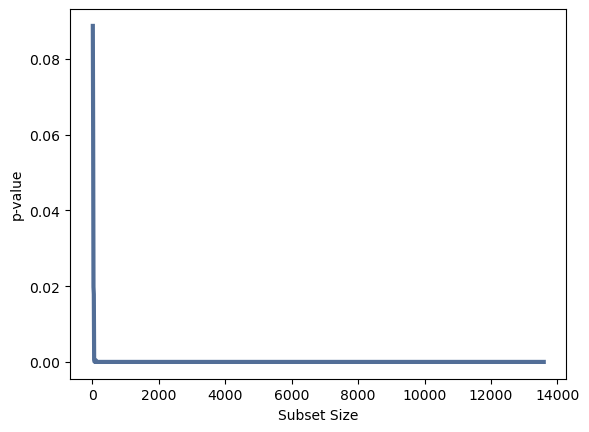

<Figure size 800x600 with 0 Axes>

In [52]:
# plot the p-values against the subset sizes to visualize the relationship
thinkplot.plot(subset_sizes, p_values)
thinkplot.Show(xlabel = 'Subset Size', ylabel = 'p-value')

In [53]:
# print the smallest sample size that yields a positive test
if smallest_sample_with_positive_test is not None:
    print(f"The smallest sample size with a positive test is {smallest_sample_with_positive_test}.")
else:
    print("No positive tests found in the tested subset sizes.")

The smallest sample size with a positive test is 30.


### Exercise 10-1

Using the data from the BRFSS, compute the linear least squares fit for log(weight) vs height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone's weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighing affect the estimates?

In [54]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

Downloaded CDBRFS08.ASC.gz


In [112]:
# import the brfss package from the ThinkStats and use the DataFrames provided

import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [113]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

In [114]:
# determine the slope and intercept for heights and weights of the dataset

slope, inter = thinkstats2.LeastSquares(heights, log_weights)
slope, inter

(0.9930804163932496, 0.005281454169418002)

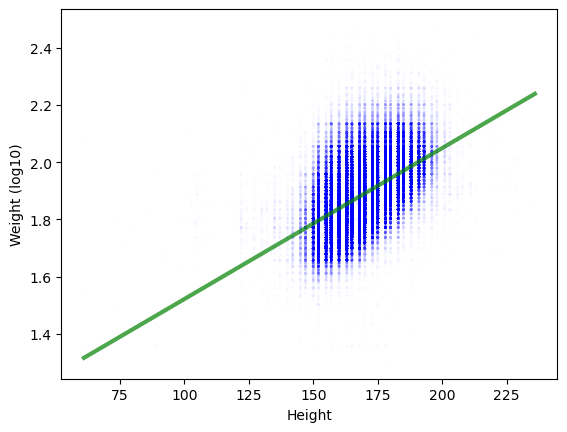

In [115]:
# create a scatterplot of the slope and intercept from the heights and weights 

thinkplot.Scatter(heights, log_weights, alpha = 0.01, s = 5)
fxs, fys = thinkstats2.FitLine(heights, slope, inter)
thinkplot.Plot(fxs, fys, color = 'green')
thinkplot.Config(xlabel = 'Height', ylabel='Weight (log10)', legend=False)

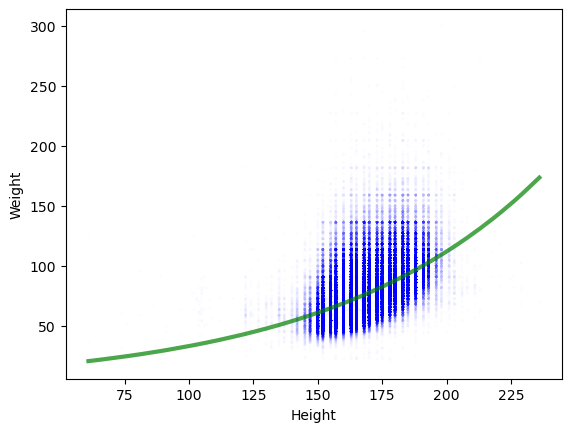

In [116]:
# create a scatterplot that shows an inverse transformation showing the plot on a linear scale

thinkplot.Scatter(heights, weights, alpha = 0.01, s = 5)
fxs, fys = thinkstats2.FitLine(heights, slope, inter)
thinkplot.Plot(fxs, 10**fys, color = 'green')
thinkplot.Config(xlabel = 'Height', ylabel = 'Weight', legend=False)

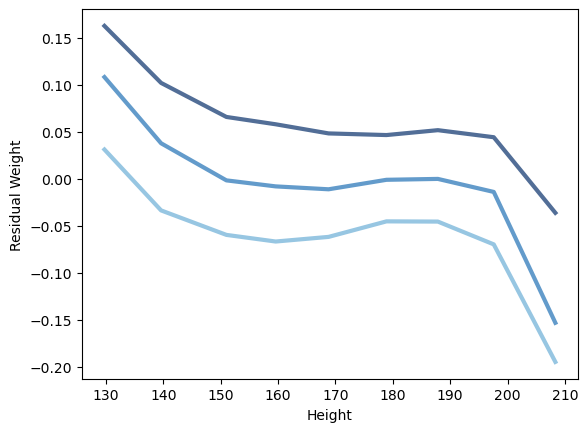

In [117]:
# calculate the residuals between 'heights' and 'log_weights' using slope and intercept values
res = thinkstats2.Residuals(heights, log_weights, slope, inter)
# add the residuals to a new DataFrame
df['residual'] = res

# create an array of bins to group the data with a range of 125 to 225, in increments of 10
bins = np.arange(125, 225, 10)
# assign the values of the htm3 column into the DataFrame based on the bin size
indices = np.digitize(df.htm3, bins)
# group the data in the DataFrame based on the indices, creating the groups based off of the htm3 column
groups = df.groupby(indices)

# find the mean height within each group, excluding the first and last groups
means = [group.htm3.mean() for i, group in groups][1:-1]
# calculate the cdf for the residuals excluding the first and last groups
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]
# create a plot of the residuals that shows the percentiles
thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)

thinkplot.Config(xlabel = 'Height', ylabel = 'Residual Weight', legend=False)

The lines seem to be mostly flat over most of the range and tend to react to each other the same, indicating that the relationship is linear. The lines are parallel from the first group to the last group, showing that the variance of the residuals is the same over the range.

In [118]:
# calculate the correlation coefficient using Pearson's correlation 
pear_corr = thinkstats2.Corr(heights, log_weights)
pear_corr

0.5317282605983575

In [119]:
# calculate the coefficient of determination often indicated ar r2
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.28273494311893366

In [120]:
# find the difference between the square of the correlation coefficient and the coefficient of determination
pear_corr**2 - r2

2.1149748619109232e-14

In [121]:
# find the standard deviation of the log_weights variable
std_logw = thinkstats2.Std(log_weights)
std_logw

0.10320725030004863

In [122]:
# find the standard deviation of the residuals
std_res = thinkstats2.Std(res)
std_res

0.087407770804161

In [123]:
# calculate a statistic that represents the proportion of the std dev in the residuals relative to the std dev of the log weights
1 - std_res / std_logw

0.15308497658793052

In [124]:
# create an empty list that stores the results of resampling and regression
resample_list = []
# run a 'for' loop that has a range of 100 times, the '_' varaible is a throwaway 
for _ in range(100):
    # create a new random sample using the ResampleRows DataFrame 
    sample = thinkstats2.ResampleRows(df)
    # use the LeastSquares function to prefrom a linear regression analysis to estimate the slope and intercept
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    # add the estimate of the slope and intercept to the list of resamples
    resample_list.append(estimates)

# unzip the slopes and intercepts of the resample list to use for further analysis    
slopes, inters = zip(*resample_list)

{'xscale': 'linear', 'yscale': 'linear'}

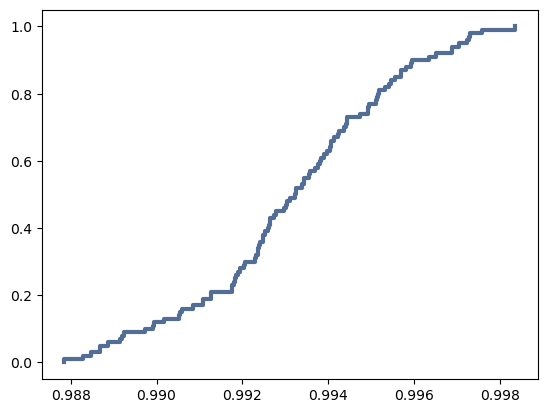

In [125]:
# find the cdf of the slope estimates from the resampling iterations 
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [126]:
# calculate the p-value based of the CDF set to 0 
pvalue = cdf[0]
pvalue

0

In [127]:
# calculate the confidence interval for the slope estimates
conf_int = cdf.Percentile(5), cdf.Percentile(95)
conf_int

(0.9886908506732351, 0.997040900353395)

In [128]:
# calculate the mean of the slope estimates 
mean = thinkstats2.Mean(slopes)
mean

0.993168042412115

In [129]:
# calculate the standard error of the slope estimates
stderr = thinkstats2.Std(slopes)
stderr

0.002333388993556141

In [130]:
# use the 'Summarize' function provided from ThinkStats to compute the mean, standard error, and 90% confidence interval.
def summary(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu = actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [131]:
# conduct resampling to estimate the unweighted mean of the heights column using the resampling 'for' loop from above code
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
summary(estimates_unweighted)

mean, SE, CI 168.9551959669759 0.016692514491045005 (168.92654712100082, 168.984260999616)


In [132]:
# use the 'ResampleRowsWeighted' function provided from ThinkStats to help find the weighted estimates from resampling
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [133]:
# conduct resampling to estimate the weighted mean of the heights column using the resampling 'for' loop from above code
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
summary(estimates_weighted)

mean, SE, CI 170.49552714282828 0.01745785207188896 (170.46716031043474, 170.52092049152165)


With the estimated mean of the weighted height being slightly bigger than the mean estimate of the unweighted by. about 2, this shows that the difference is much larger than the orginal sampling error indicated. 